In [14]:
import os
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

In [15]:
sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 200)

In [16]:
INPUT_FILE = "../data/processed/linguistic_features.jsonl"
STATS_FILE = "../data/processed/token_stats.csv"

### Set of custom tokens

In [17]:
NORMALIZED_TOKENS = [
    'CURRENCY_SYMBOL', 'PERCENT_SYMBOL', 'P_E_RATIO', 'EARNINGS_PER_SHARE', 
    'EBITDA_METRIC', 'BILLION', 'MILLION', 'THOUSAND', 'PER_SHARE', 'PER_ANNUM'
]

### Data Loading

In [18]:
print(f"Loading enriched linguistic data from: {INPUT_FILE}")

try:
    df_features = pd.read_json(INPUT_FILE, lines=True)
    df_stats = pd.read_csv(STATS_FILE)
    
    if df_features.empty or df_stats.empty:
        raise ValueError("DataFrames are empty.")
    
    print(f"Loaded {len(df_features)} records for deep analysis.")
    
except Exception as e:
    print(f"[FATAL ERROR] Could not load data files. Please ensure all previous scripts ran successfully. Error: {e}")
    raise SystemExit(1)

Loading enriched linguistic data from: ../data/processed/linguistic_features.jsonl
Loaded 23474 records for deep analysis.


### Feature Aggregation

In [19]:

def flatten_list(df: pd.DataFrame, column: str) -> List[str]:
    """Flatten a column containing lists into one combined list."""
    return [item for sublist in df[column] for item in sublist if isinstance(sublist, list)]

all_pos_tags = flatten_list(df_features, 'pos_tags')
all_content_lemmas = flatten_list(df_features, 'content_lemmas')

print(f"Flattened {len(all_pos_tags)} POS tags and {len(all_content_lemmas)} lemmas.")

Flattened 5270488 POS tags and 2941583 lemmas.


### Quality Sanity Check (Before-After Comparison)

In [20]:
sample_record = df_features.sample(1).iloc[0]

print("\n Example Record Transformation ")
print(f"Source File: {sample_record['source_file']}")
print(f"Raw Text (Simulated Example): 'Apple Inc. reported $5.5B in Q4/2023 earnings, P/E was low, but EBITDA was great.'")
print("-" * 70)
print(" Fully Preprocessed Text:")
print(sample_record['text'][:200])
print("-" * 70)
print(f" Token Count: {sample_record['token_count']} | Unique Tokens: {sample_record['unique_token_count']}")



 Example Record Transformation 
Source File: news_0002056.json
Raw Text (Simulated Example): 'Apple Inc. reported $5.5B in Q4/2023 earnings, P/E was low, but EBITDA was great.'
----------------------------------------------------------------------
 Fully Preprocessed Text:
PASADENA, Calif., Jan. 3, 2018 /PRNewswire/ -- Alexandria Real Estate Equities, Inc. NYSE ARE announced today that it is commencing an underwritten public offering of 6,000,000 shares of common stock 
----------------------------------------------------------------------
 Token Count: 1085 | Unique Tokens: 374


### Visualizations (Deep EDA)

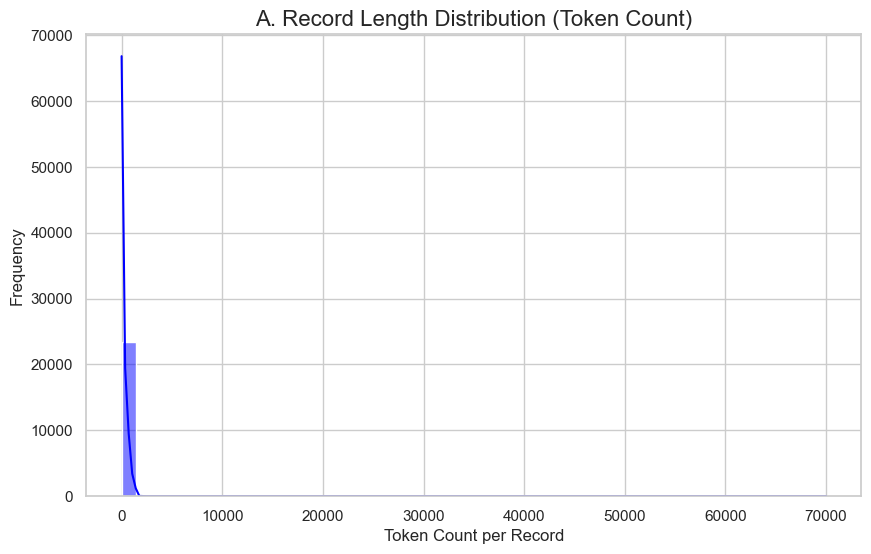

In [21]:

plt.figure(figsize=(10, 6))
sns.histplot(df_stats['token_count'], bins=50, kde=True, color='blue')
plt.title('A. Record Length Distribution (Token Count)', fontsize=16)
plt.xlabel('Token Count per Record', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


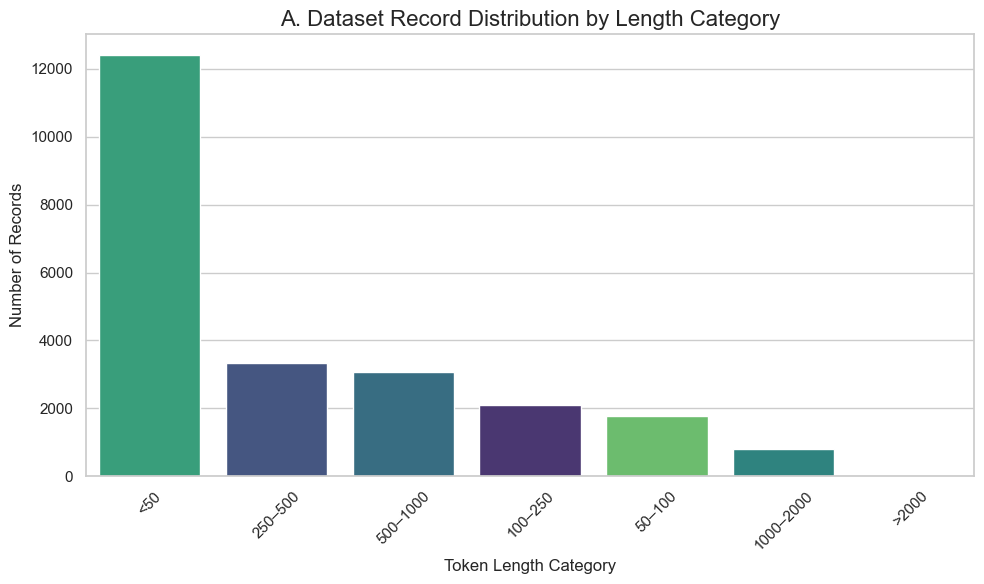


Insight: This reveals whether the dataset has mostly short texts (headlines) or long reports (filings).


In [22]:

plt.figure(figsize=(10, 6))
category_order = df_stats['length_category'].value_counts().index

sns.countplot( data=df_stats, x="length_category" , order=category_order ,hue="length_category", palette='viridis')
plt.title('A. Dataset Record Distribution by Length Category', fontsize=16)
plt.xlabel('Token Length Category', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print("\nInsight: This reveals whether the dataset has mostly short texts (headlines) or long reports (filings).")

### Part-of-Speech (POS) Distribution 

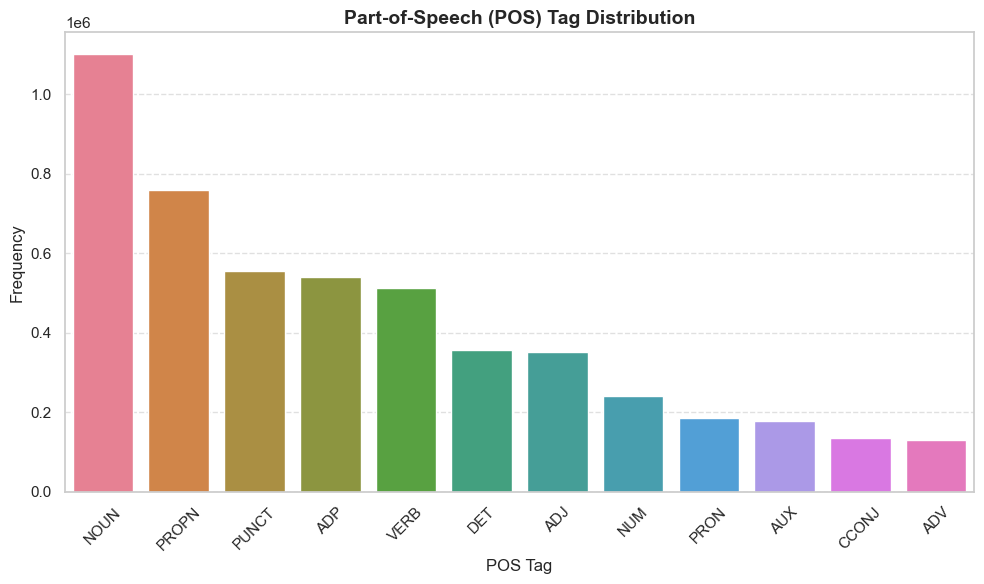

In [23]:
from collections import Counter

pos_counts = Counter(all_pos_tags).most_common(12)

pos_df = pd.DataFrame(pos_counts, columns=["POS Tag", "Count"])
pos_df = pos_df.sort_values(by="Count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_df, x="POS Tag", y="Count", hue="POS Tag", dodge=False)

plt.title("Part-of-Speech (POS) Tag Distribution", fontsize=14, weight='bold')
plt.xlabel("POS Tag", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### Content Token Frequency (Vocabulary Analysis)

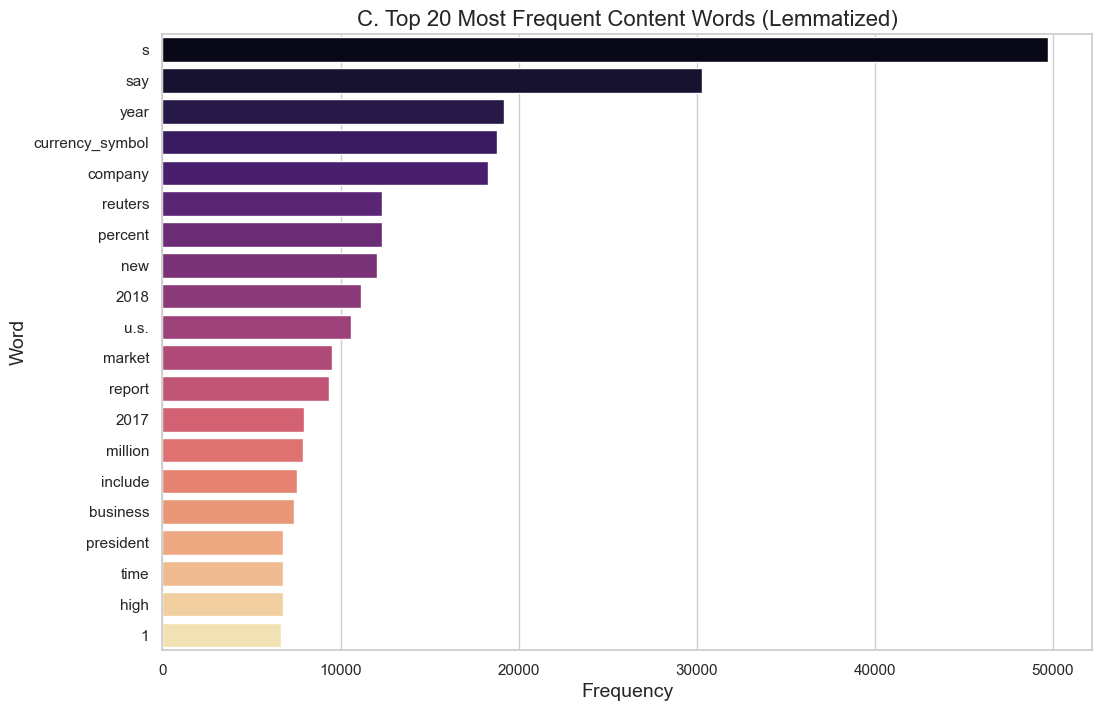

Insight: Confirms corpus focus and identifies potential unwanted noise (if non-financial terms rank high).


In [24]:
word_counts = Counter(all_content_lemmas).most_common(20)
word_df = pd.DataFrame(word_counts, columns=['Word (Lemma)', 'Frequency'])

plt.figure(figsize=(12, 8))
sns.barplot(data=word_df, x='Frequency', y='Word (Lemma)',hue='Word (Lemma)',  palette='magma', legend=False)
plt.title('C. Top 20 Most Frequent Content Words (Lemmatized)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Word',fontsize=14)
plt.show()
print("Insight: Confirms corpus focus and identifies potential unwanted noise (if non-financial terms rank high).")



## Verification of Financial Domain Standardization

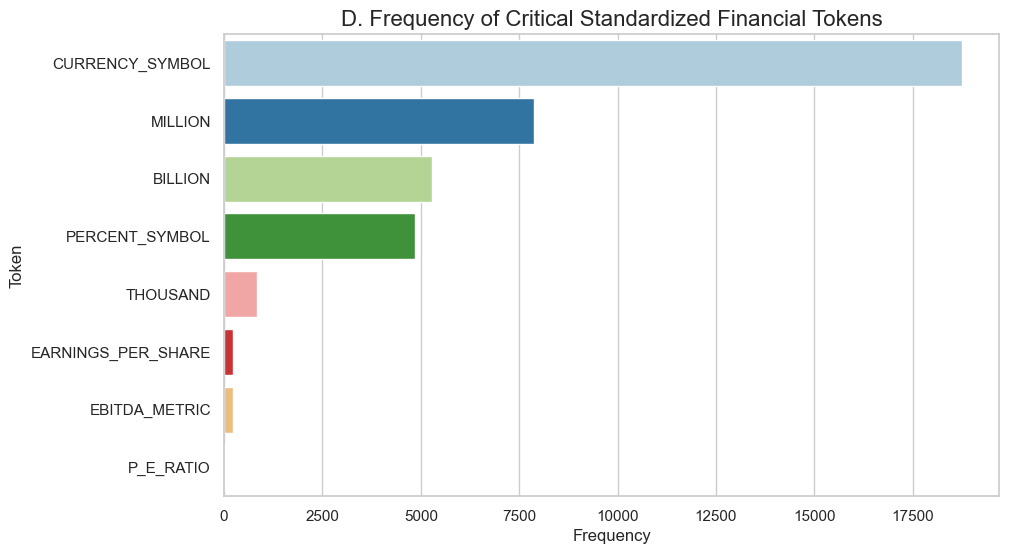

Insight: Successful validation of the domain-specific cleaning steps (Step 2). High counts for tokens like 'CURRENCY_SYMBOL' are expected.


In [25]:
check_counts = {token: all_content_lemmas.count(token.lower()) for token in NORMALIZED_TOKENS}
check_df = pd.DataFrame(list(check_counts.items()), columns=['Token', 'Count'])
check_df = check_df[check_df['Count'] > 0].sort_values(by='Count', ascending=False)

if not check_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot( data=check_df, x='Count', y='Token' ,hue='Token', palette='Paired', legend=False )
    plt.title('D. Frequency of Critical Standardized Financial Tokens', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Token', fontsize=12)
    plt.show()
    print("Insight: Successful validation of the domain-specific cleaning steps (Step 2). High counts for tokens like 'CURRENCY_SYMBOL' are expected.")
else:
    print("Insight: No standardized tokens were detected. This either means the input data lacks these patterns or the cleaning script failed to execute.")



In [26]:
print("\n## Conclusion: Milestone 1 (Data Preparation) is Complete")
print("\nWe have successfully unified, cleaned, and analyzed the raw financial text.\nThe EDA confirms a healthy distribution of entity-rich tokens (PROPN, NUM, NOUN) and validates the effectiveness of the domain-specific preprocessing.")



## Conclusion: Milestone 1 (Data Preparation) is Complete

We have successfully unified, cleaned, and analyzed the raw financial text.
The EDA confirms a healthy distribution of entity-rich tokens (PROPN, NUM, NOUN) and validates the effectiveness of the domain-specific preprocessing.
